# Spork experiments analysis

## Required libraries

* pandas==1.2.0
* scipy==1.7.1
* seaborn==0.11.0
* matplotlib==3.3.3
* numpy==1.19.5
* pingouin==0.4.0

## Installation

`pip install -r requirements.txt`

## Imports

In [1]:
import pathlib
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
import itertools
import math

## Directories set-up

In [2]:
sns.set(font_scale=3, palette="pastel", style="ticks", context="paper")

plt.rcParams["figure.figsize"] = (20,3)

TOOLS = ["spork", "jdime", "automergeptm"]
FILE_MERGE_EVALS = pd.read_csv("analysis/results/file_merge_evaluations.csv")

# merge directories in which JDime or Spork (or both) exhibit fails/conflicts
FAIL_MERGE_DIRS = set(FILE_MERGE_EVALS.query("outcome == 'fail' or outcome == 'timeout'").merge_dir.unique())
CONFLICT_MERGE_DIRS = set(
    FILE_MERGE_EVALS.query("outcome == 'conflict'").merge_dir.unique()
)

FILE_MERGE_EVALS.head()

,owner,repo,merge_commit,merge_dir,base_blob,left_blob,right_blob,expected_blob,replayed_blob,merge_cmd,outcome,line_diff_size,char_diff_size,char_diff_ratio,num_conflicts,conflict_size,num_syntax_errors,runtime
0,rackerlabs,atom-hopper,01be79d397cb824621eadcaded53b8bde7b6f657,rackerlabs/atom-hopper/01be79d397cb824621eadca...,4a25af165b3444ccdd28ab094399da128d2a7d98,19130f1069de3cd5868bafa03b44058af074513f,84ce7dcde1d0feefc0e8ea26164ffcb629d4a245,81eedf146f11bf224c2926a76b2b0cafc7cac4a9,53c81aed33ccdf40151ab165146689f7a8f8e7e0,jdime,success,210,651,0.949113,0,0,0,0.896167
1,rackerlabs,atom-hopper,01be79d397cb824621eadcaded53b8bde7b6f657,rackerlabs/atom-hopper/01be79d397cb824621eadca...,4a25af165b3444ccdd28ab094399da128d2a7d98,19130f1069de3cd5868bafa03b44058af074513f,84ce7dcde1d0feefc0e8ea26164ffcb629d4a245,81eedf146f11bf224c2926a76b2b0cafc7cac4a9,8d4341bb2ab36ee0e59e643c5584add0c2962ed8,automergeptm,success,212,771,0.939733,0,0,0,1.059407
2,rackerlabs,atom-hopper,01be79d397cb824621eadcaded53b8bde7b6f657,rackerlabs/atom-hopper/01be79d397cb824621eadca...,4a25af165b3444ccdd28ab094399da128d2a7d98,19130f1069de3cd5868bafa03b44058af074513f,84ce7dcde1d0feefc0e8ea26164ffcb629d4a245,81eedf146f11bf224c2926a76b2b0cafc7cac4a9,2fbbc3029f3d4be43eb1f90cfcdd4558559b7f77,spork,success,47,1206,0.909812,0,0,0,0.983729
3,rackerlabs,atom-hopper,0288e1abce0e7c51046007f7bd9061a3013056c5,rackerlabs/atom-hopper/0288e1abce0e7c51046007f...,310817a11fc12d80e16b0b73c123cfcb9e327747,15cac82ce3f5672300bb9a5c6a098f4273a2facd,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,82807e7519510a0383e45a59ecaa50db1d044400,jdime,success,472,3581,0.866981,0,0,0,0.703220
4,rackerlabs,atom-hopper,0288e1abce0e7c51046007f7bd9061a3013056c5,rackerlabs/atom-hopper/0288e1abce0e7c51046007f...,310817a11fc12d80e16b0b73c123cfcb9e327747,15cac82ce3f5672300bb9a5c6a098f4273a2facd,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,d68aa3696dcfcd9073728a18cc6afc93aa556b0a,10c7c948e7be8c2a07b715a958d38da0ac1c97a0,automergeptm,success,474,3655,0.864232,0,0,0,0.751237


## Utility functions

In [3]:
def histogram(data, bins, xlabel, ylabel="Frequency", bound_to_label=None):
    bound_to_label = bound_to_label or {}
    spork_values = data.spork
    jdime_values = data.jdime
    automergeptm_values = data.automergeptm

    smallest_value = min(
        0, min(itertools.chain(spork_values, jdime_values, automergeptm_values))
    )
    largest_value = max(
        itertools.chain(spork_values, jdime_values, automergeptm_values)
    )

    has_lower_bound = smallest_value >= bins[0]
    has_upper_bound = largest_value < bins[-1]

    def get_ticklabel(bin_value):
        if bin_value in bound_to_label:
            return bound_to_label[bin_value]
        if bin_value == bins[0] and not has_lower_bound:
            return str(int(math.floor(smallest_value)))
        elif bin_value == bins[-1] and not has_upper_bound:
            # bins are exclusive to the right, so max bin must be 1 larger
            max_bin = int(math.ceil(largest_value + 1))
            return str(max_bin)
        else:
            return str(bin_value)

    # limits values to be in the range of bins, but does not remove any values
    clipped_spork_values = np.clip(spork_values, bins[0], bins[-1])
    clipped_jdime_values = np.clip(jdime_values, bins[0], bins[-1])
    clipped_automergeptm_values = np.clip(automergeptm_values, bins[0], bins[-1])

    _, ax = plt.subplots()
    plt.hist(
        [clipped_spork_values, clipped_jdime_values, clipped_automergeptm_values],
        bins=bins,
    )
    set_hatches(ax)

    handles = [ax.patches[0], ax.patches[len(ax.patches) // 2], ax.patches[-1]]
    labels = ["Spork", "JDime", "AutoMergePTM"]
    plt.legend(handles, labels)
    plt.xticks(bins)
    plt.tick_params(axis="both", which="major", labelsize=20)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    ticklabels = list(map(get_ticklabel, bins))
    ax.set_xticklabels(ticklabels)

    #print(spork_values.describe())
    #print(jdime_values.describe())
    #print(automergeptm_values.describe())

    friedman = scipy.stats.friedmanchisquare(spork_values, jdime_values, automergeptm_values)
    spork_vs_jdime = pg.wilcoxon(spork_values, jdime_values)
    spork_vs_automergeptm = pg.wilcoxon(spork_values, automergeptm_values)
    reject, p_vals = pg.multicomp([spork_vs_jdime["p-val"], spork_vs_automergeptm["p-val"]])
    print(f"Friedman Chi Squared p-value: {friedman.pvalue}")
    print("Spork vs JDime")
    print("P-value: " + str(p_vals[0]) + ", RBC: " + str(spork_vs_jdime["RBC"][0]))
    print("Spork vs AutoMergePTM")
    print("P-value: " + str(p_vals[1]) + ", RBC: " + str(spork_vs_automergeptm["RBC"][0]))

    return plt

def set_hatches(ax):
    for patch in ax.patches[len(ax.patches) // 3 :]:
        patch.set_hatch("/")
    for patch in ax.patches[int(2 / 3 * len(ax.patches)) :]:
        patch.set_hatch("x")


def get_aligned_mean_conflict_sizes():
    non_fail_conflict_dirs = CONFLICT_MERGE_DIRS - FAIL_MERGE_DIRS
    non_fail_conflict_merges = FILE_MERGE_EVALS[
        FILE_MERGE_EVALS.merge_dir.isin(non_fail_conflict_dirs)
    ]

    return (
        non_fail_conflict_merges.groupby(["merge_dir", "merge_cmd"])[
            ["num_conflicts", "conflict_size"]
        ]
        .apply(avg_chunk_size)
        .unstack()
    )


def avg_chunk_size(row):
    return int(row.conflict_size) / max(1, int(row.num_conflicts))


def compute_median_running_times(running_times: pd.DataFrame) -> pd.DataFrame:
    return (
        running_times.groupby(["merge_dir", "merge_cmd"])["running_time"]
        .median()
        .unstack()
    )


def print_size_compared_to_spork(frame: pd.DataFrame) -> None:
    print("Amount of cases where where SPORK's results are lesser, equal, greater:")

    def compute_comparison(cmp: str) -> str:
        amount = len(frame.query(cmp))
        return f"\t{cmp}: {amount}"
        
    for tool in filter(lambda t: t != 'spork', TOOLS):
        print(compute_comparison(f"spork < {tool}"))
        print(compute_comparison(f"spork == {tool}"))
        print(compute_comparison(f"spork > {tool}"))

        
def print_tool_results(data: pd.DataFrame, callback) -> None:
    results = {}
    for tool in TOOLS:
        results[tool] = callback(getattr(data, tool))
        print(f"\t{tool.upper()}: {results[tool]}")

    for tool in filter(lambda t: t != 'spork', TOOLS):
        spork_result = results["spork"]
        other_result = results[tool]
        diff = other_result - spork_result
        reduction = 100 * (other_result - spork_result) / other_result
        print(f"\tSPORK reduction vs {tool.upper()}: absolute={diff}, percentage={reduction:.2f}%")

## Line diff size

Amount of file merges considered:
	1402
Median diff sizes per tool
	SPORK: 65.0
	JDIME: 308.5
	AUTOMERGEPTM: 314.5
	SPORK reduction vs JDIME: absolute=243.5, percentage=78.93%
	SPORK reduction vs AUTOMERGEPTM: absolute=249.5, percentage=79.33%
Max diff sizes per tool
	SPORK: 3256
	JDIME: 9677
	AUTOMERGEPTM: 9677
	SPORK reduction vs JDIME: absolute=6421, percentage=66.35%
	SPORK reduction vs AUTOMERGEPTM: absolute=6421, percentage=66.35%
Amount of cases where where SPORK's results are lesser, equal, greater:
	spork < jdime: 1336
	spork == jdime: 3
	spork > jdime: 63
	spork < automergeptm: 1341
	spork == automergeptm: 3
	spork > automergeptm: 58
Friedman Chi Squared p-value: 0.0
Spork vs JDime
P-value: 1.850793713072793e-213, RBC: -0.9627080567752477
Spork vs AutoMergePTM
P-value: 1.850793713072793e-213, RBC: -0.9631645052588584


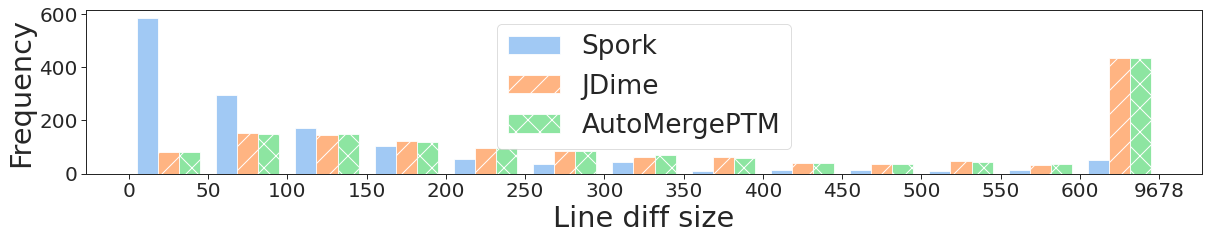

In [4]:
def plot_git_diff_sizes():
    filtered_file_merges = FILE_MERGE_EVALS[
        ~FILE_MERGE_EVALS.merge_dir.isin(FAIL_MERGE_DIRS | CONFLICT_MERGE_DIRS)
    ]
    aligned_file_merges = (
        filtered_file_merges.groupby(["merge_dir", "merge_cmd"])
        .line_diff_size.sum()
        .unstack()
    )
    bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
    print_diff_size_details(aligned_file_merges)
    histogram(
        aligned_file_merges,
        bins=bins,
        xlabel="Line diff size",
    )

    
def print_diff_size_details(diff_sizes: pd.DataFrame) -> None:
    print(f"Amount of file merges considered:\n\t{len(diff_sizes)}")

    print("Median diff sizes per tool")
    print_tool_results(diff_sizes, callback=np.median)

    print("Max diff sizes per tool")
    print_tool_results(diff_sizes, callback=np.max)

    print_size_compared_to_spork(diff_sizes)


plot_git_diff_sizes()
    

## Character size

Amount of file merges considered:
	1402
Median diff sizes per tool
	SPORK: 528.0
	JDIME: 2181.0
	AUTOMERGEPTM: 2430.5
	SPORK reduction vs JDIME: absolute=1653.0, percentage=75.79%
	SPORK reduction vs AUTOMERGEPTM: absolute=1902.5, percentage=78.28%
Max diff sizes per tool
	SPORK: 32595
	JDIME: 184999
	AUTOMERGEPTM: 184999
	SPORK reduction vs JDIME: absolute=152404, percentage=82.38%
	SPORK reduction vs AUTOMERGEPTM: absolute=152404, percentage=82.38%
Amount of cases where where SPORK's results are lesser, equal, greater:
	spork < jdime: 1286
	spork == jdime: 0
	spork > jdime: 116
	spork < automergeptm: 1301
	spork == automergeptm: 0
	spork > automergeptm: 101
Friedman Chi Squared p-value: 0.0
Spork vs JDime
P-value: 1.2889704249830537e-199, RBC: -0.9294328537889565
Spork vs AutoMergePTM
P-value: 2.259337680435125e-205, RBC: -0.9435761761784154


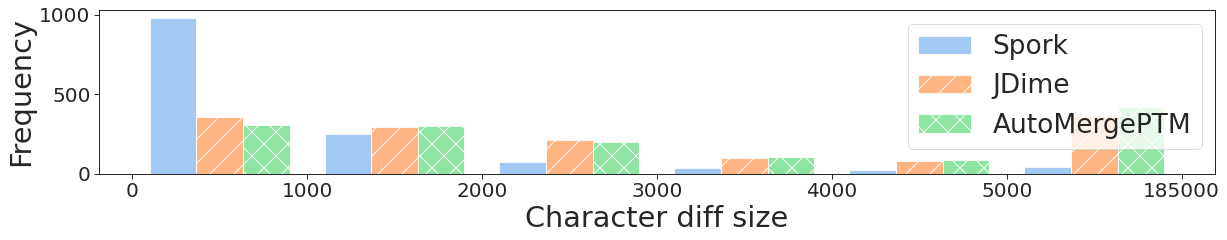

In [5]:
def plot_char_diff_size():
    bins = [0, 1000, 2000, 3000, 4000, 5000, 6000]
    filtered_file_merges = FILE_MERGE_EVALS[
        ~FILE_MERGE_EVALS.merge_dir.isin(FAIL_MERGE_DIRS | CONFLICT_MERGE_DIRS)
    ]
    aligned_file_merges = (
        filtered_file_merges.groupby(["merge_dir", "merge_cmd"])
        .char_diff_size.sum()
        .unstack()
    )
    print_diff_size_details(aligned_file_merges)
    histogram(
        aligned_file_merges,
        bins=bins,
        xlabel="Character diff size",
    )


def plot_char_diff_ratio():
    bins = [0.75, 0.8, 0.85, 0.9, 0.95, 1]
    filtered_file_merges = FILE_MERGE_EVALS[
        ~FILE_MERGE_EVALS.merge_dir.isin(FAIL_MERGE_DIRS | CONFLICT_MERGE_DIRS)
    ]
    aligned_file_merges = (
        filtered_file_merges.groupby(["merge_dir", "merge_cmd"])
        .char_diff_ratio.sum()
        .unstack()
    )
    histogram(
        aligned_file_merges,
        bins=bins,
        xlabel="Character diff ratio",
    )


plot_char_diff_size()

## Number of conflicts

Amount of file merges with at least one conflict from one tool:
	255
Amount of files with conflicts per tool:
	SPORK: 125
	JDIME: 191
	AUTOMERGEPTM: 145
	SPORK reduction vs JDIME: absolute=66, percentage=34.55%
	SPORK reduction vs AUTOMERGEPTM: absolute=20, percentage=13.79%
Total amount of conflict hunks per tool:
	SPORK: 227
	JDIME: 376
	AUTOMERGEPTM: 245
	SPORK reduction vs JDIME: absolute=149, percentage=39.63%
	SPORK reduction vs AUTOMERGEPTM: absolute=18, percentage=7.35%
Amount of cases where where SPORK's results are lesser, equal, greater:
	spork < jdime: 145
	spork == jdime: 48
	spork > jdime: 62
	spork < automergeptm: 109
	spork == automergeptm: 60
	spork > automergeptm: 86
Friedman Chi Squared p-value: 2.3983540258582085e-13
Spork vs JDime
P-value: 7.987207035801007e-08, RBC: -0.42316982534373837
Spork vs AutoMergePTM
P-value: 0.26855247978220076, RBC: -0.08649921507064362


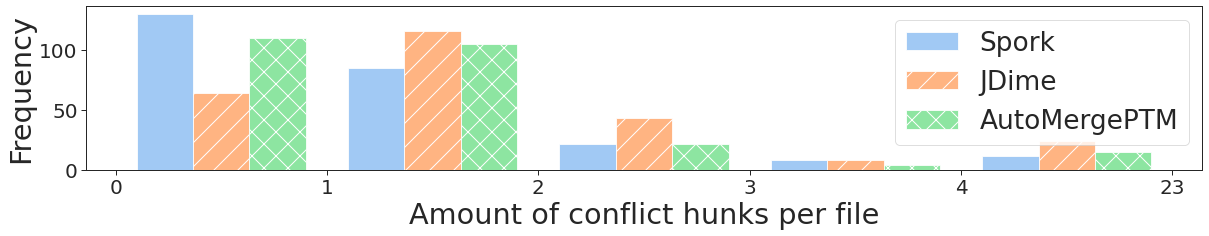

In [6]:
def plot_conflict_hunk_quantities():
    bins = [0, 1, 2, 3, 4, 5]
    non_fail_conflict_dirs = CONFLICT_MERGE_DIRS - FAIL_MERGE_DIRS
    aligned_conflicts = (
        FILE_MERGE_EVALS[FILE_MERGE_EVALS.merge_dir.isin(non_fail_conflict_dirs)]
        .groupby(["merge_dir", "merge_cmd"])
        .num_conflicts.sum()
        .unstack()
    )
    print_conflict_quantity_details(aligned_conflicts)
    histogram(
        aligned_conflicts,
        bins=bins,
        xlabel="Amount of conflict hunks per file",
    )


def print_conflict_quantity_details(conflicts: pd.DataFrame) -> None:
    print(
        f"Amount of file merges with at least one conflict from one tool:\n\t{len(conflicts)}"
    )

    print(f"Amount of files with conflicts per tool:")
    print_tool_results(conflicts, callback=np.count_nonzero)

    print(f"Total amount of conflict hunks per tool:")
    print_tool_results(conflicts, callback=np.sum)

    print_size_compared_to_spork(conflicts)


plot_conflict_hunk_quantities()

## Conflicts size

Friedman Chi Squared p-value: 6.816767645043923e-08
Spork vs JDime
P-value: 0.004163537582615153, RBC: -0.23480566059802732
Spork vs AutoMergePTM
P-value: 0.4934159370919269, RBC: -0.05392479487516999


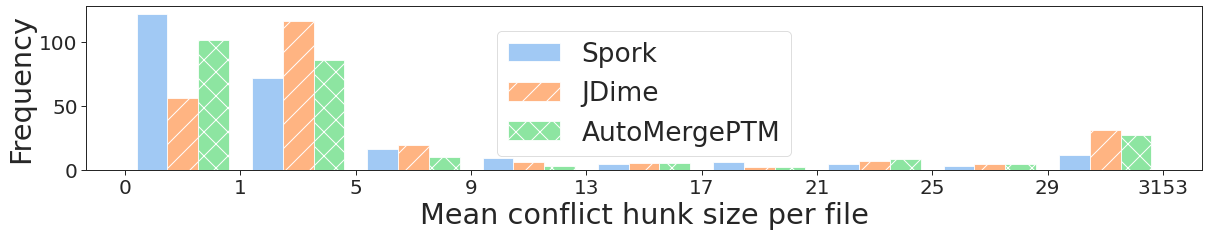

In [8]:
def plot_mean_conflict_sizes():
    # note: using [-3, 1) as the first bin is a hack to ensure that all bins
    # are of equal size, graphically
    left_bound = -3
    bins = [left_bound, 1, 5, 9, 13, 17, 21, 25, 29, 33]
    aligned_mean_conflict_sizes = get_aligned_mean_conflict_sizes().query(
        "spork > 0 or jdime > 0 or automergeptm > 0"
    )
    histogram(
        aligned_mean_conflict_sizes,
        bins=bins,
        xlabel="Mean conflict hunk size per file",
        bound_to_label={left_bound: "0"},
    )

plot_mean_conflict_sizes()

## Runtime

Amount of merge scenarios where all tools succeed:
	1667
Sum of medians per tool:
	SPORK: 2435.4386842918498
	JDIME: 4937.148695311921
	AUTOMERGEPTM: 5387.915904920003
	SPORK reduction vs JDIME: absolute=2501.7100110200713, percentage=50.67%
	SPORK reduction vs AUTOMERGEPTM: absolute=2952.4772206281536, percentage=54.80%
Median of running times per tool:
	SPORK: 1.1780378950061277
	JDIME: 1.3154052189984213
	AUTOMERGEPTM: 1.4846605484999602
	SPORK reduction vs JDIME: absolute=0.13736732399229368, percentage=10.44%
	SPORK reduction vs AUTOMERGEPTM: absolute=0.30662265349383255, percentage=20.65%
Max running times per tool:
	SPORK: 11.890217963999023
	JDIME: 287.87619982899923
	AUTOMERGEPTM: 287.6714485789962
	SPORK reduction vs JDIME: absolute=275.9859818650002, percentage=95.87%
	SPORK reduction vs AUTOMERGEPTM: absolute=275.7812306149972, percentage=95.87%
Amount of timeouts per tool:
	SPORK: 0
	JDIME: 16
	AUTOMERGEPTM: 7
Amount of running times per tool < .5 seconds
	SPORK: 0
	JDIME:

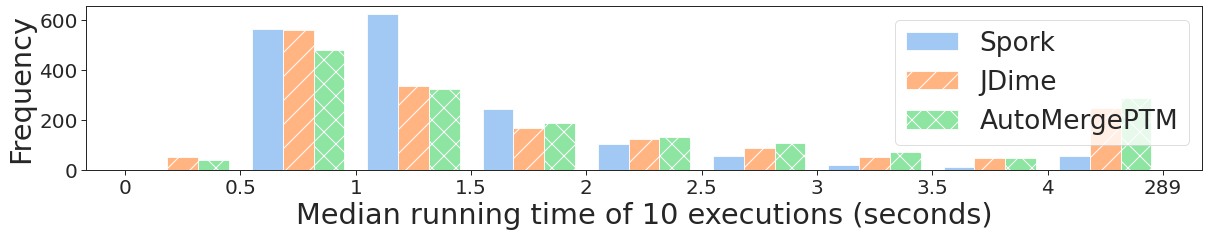

In [9]:
def plot_runtimes():
    running_times = pd.read_csv("analysis/results/running_times.csv")
    bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
    median_running_times = compute_median_running_times(running_times)
    print_running_time_details(median_running_times)
    histogram(
        median_running_times,
        bins=bins,
        xlabel="Median running time of 10 executions (seconds)",
    )


def print_running_time_details(running_times: pd.DataFrame) -> None:
    print(f"Amount of merge scenarios where all tools succeed:\n\t{len(running_times)}")

    print("Sum of medians per tool:")
    print_tool_results(running_times, callback=np.sum)

    print("Median of running times per tool:")
    print_tool_results(running_times, callback=np.median)

    print("Max running times per tool:")
    print_tool_results(running_times, callback=np.max)

    print(f"Amount of timeouts per tool:")
    for tool in TOOLS:
        num_timeouts = len(
            FILE_MERGE_EVALS.query(f"merge_cmd == '{tool}' and outcome == 'timeout'")
        )
        print(f"\t{tool.upper()}: {num_timeouts}")

    def count(predicate):
        def _count(data):
            return sum(int(predicate(v)) for v in data if predicate(v))

        return _count

    print("Amount of running times per tool < .5 seconds")
    print_tool_results(running_times, callback=count(lambda x: x < 0.5))

    print("Amount of running times per tool >= 4 seconds")
    print_tool_results(running_times, callback=count(lambda x: x >= 4))

    print_size_compared_to_spork(running_times)


plot_runtimes()